In [7]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number - filename
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 1 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 200

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 64 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-3,3)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10


Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

2021-03-03 14:36:25,415 INFO -------------------- Start --------------------
2021-03-03 14:36:25,416 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-03-03 14:36:25,416 INFO Log file: ./logs/temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0.log
2021-03-03 14:36:25,417 INFO Log level for console: DEBUG
2021-03-03 14:36:25,421 INFO Is built with tensorflow: True
2021-03-03 14:36:25,422 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-03-03 14:36:25,429 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-03_14_36', 'MODEL_PATH': 'exp/temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-03_14_36/model', 'TENSORBOARD_PATH': 'exp/temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-03_14_36/tensorboard_logs', 'CONFIG_PATH': 'exp/temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-03_14_36/config', 'HISTORY_PATH': 'exp/temp_/8_64_64__8_3_3_tenc64_conv1_MSE_smooth02_augNO_taug3_3_batch8_f0/2021-03-03_14_36/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/', 'DF_FOLDS': '/mnt/ssd/data/gcn/02_impor

In [8]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-03-03 14:36:25,529 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-03-03 14:36:25,534 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-03-03 14:36:25,535 INFO Patients train: 209
2021-03-03 14:36:25,545 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-03-03 14:36:25,546 INFO SAX train CMR: 209, SAX train masks: 209
2021-03-03 14:36:25,546 INFO SAX val CMR: 69, SAX val masks: 69


In [9]:
# check if we find each patient in the corresponding dataframe
import re
import pandas as pd
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

In [10]:
files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))
info('Done!')

2021-03-03 14:36:25,910 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-03-03 14:36:26,159 INFO Done!


In [11]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [25]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-03-03 14:59:23,372 INFO Create DataGenerator
2021-03-03 14:59:23,374 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 209 
 Augment: True 
 Thread workers: 1
2021-03-03 14:59:23,374 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-03-03 14:59:23,387 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-03 14:59:23,388 INFO Temporal phase augmentation: 
True
Repeat volume: 
True
2021-03-03 14:59:23,388 INFO Create DataGenerator
2021-03-03 14:59:23,389 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 69 
 Augment: False 
 Thread workers: 1
2021-03-03 14:59:23,389 INFO No augmentation
2021-03-03 14:59:23,403 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-03 14:59:23,404 INFO Temporal phase augmentation: 
False
Repeat volume: 
True


In [26]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
        """f, axs = plt.subplots(1,2,figsize=(12,4))
        i = 0
        temp_y = selected_output
        print(np.sum(temp_y, axis=1))

        # ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0) # before we had the gt mask
        ind_gt = np.argmax(temp_y * selected_gt_len_msk, axis=1)
        axs[0].title.set_text('y')
        axs[0].set_xticks(ind_gt, minor=False)
        axs[0].set_yticks([0,1,2,3,4], minor=False)
        axs[0].set_yticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto', )
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()"""
    
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))


interactive(children=(IntSlider(value=104, description='batch', max=209), IntSlider(value=0, description='im',…

In [ ]:
# test if all batches are processable
for b in range(len(batch_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)

In [ ]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

In [7]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

NameError: name 'os' is not defined

In [8]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

NameError: name 'model' is not defined

In [9]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

NameError: name 'model' is not defined

In [10]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

NameError: name 'np' is not defined

In [11]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

NameError: name 'tf' is not defined

In [12]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases_transpose(outputs,outputs)

ImportError: cannot import name 'show_phases'

In [13]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff, meandiff_transpose
score_fn = meandiff_transpose
score_fn(outputs, outputs).numpy()

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [14]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

NameError: name 'outputs' is not defined

In [15]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

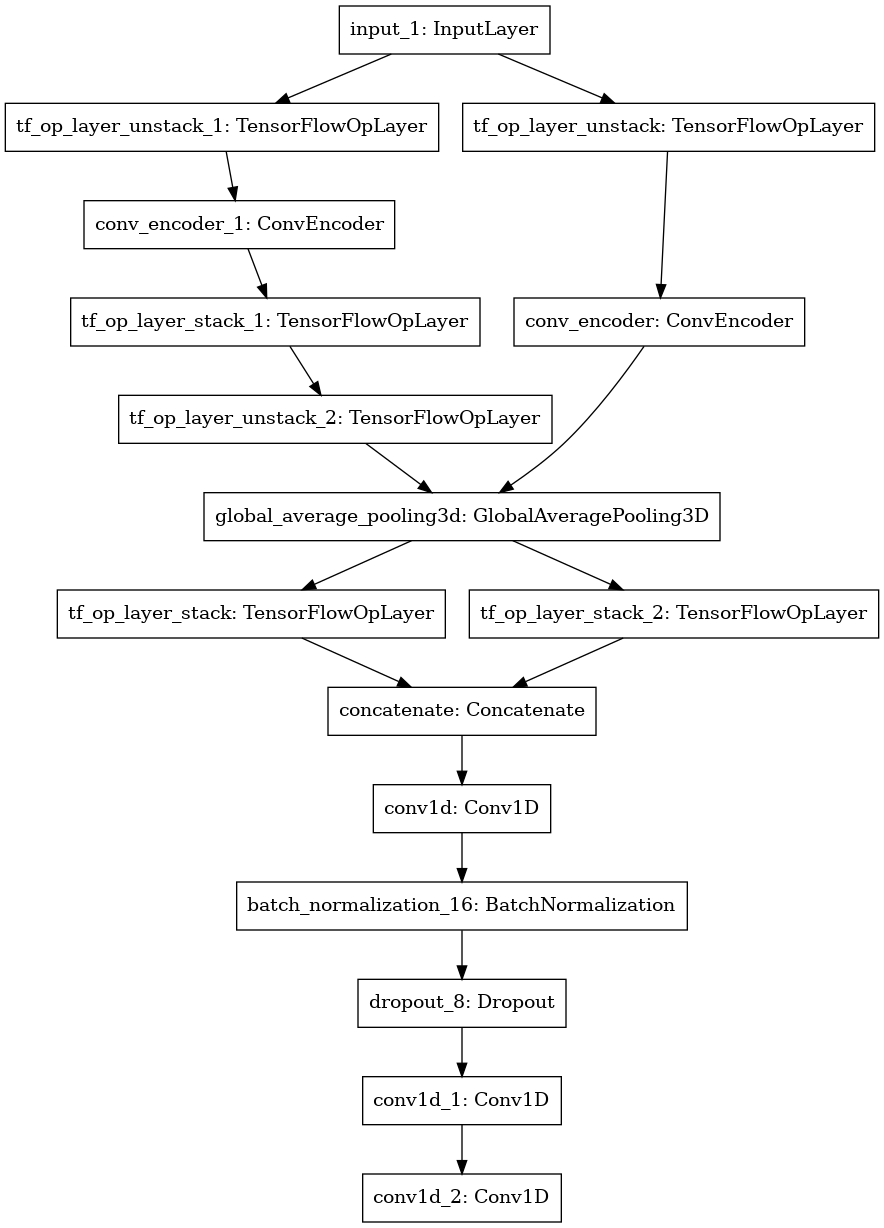

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)